In [1]:
# installation via PyPI
!pip install -U mobile-env
!pip install numpngw # for video render

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.9/953.9 kB 11.4 MB/s eta 0:00:00


In [2]:
import warnings
# Ignoring a specific deprecation warning
warnings.filterwarnings("ignore")

In [3]:
import gymnasium
import matplotlib.pyplot as plt
import mobile_env
import numpy as np
from numpngw import write_apng
from IPython.display import Image, display
import seaborn as sns
sns.set_style("whitegrid")


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim

In [5]:
# overall number of active connections
def overall_connections(sim):
    return sum([len(conns) for conns in sim.connections.values()])


# monitors utility per user equipment
def user_utility(sim):
    return {ue.ue_id: utility for ue, utility in sim.utilities.items()}


# monitors each user equipments' distance to their closest base station
def user_closest_distance(sim):
    # position vector of basestations
    bpos = np.array([[bs.x, bs.y] for bs in sim.stations.values()])

    distances = {}
    for ue_id, ue in sim.users.items():
        upos = np.array([[ue.x, ue.y]])
        dist = np.sqrt(np.sum((bpos - upos)**2, axis=1)).min()

        distances[ue_id] = dist

    return distances


# number of connections per basestation
def station_connections(sim):
    return {bs.bs_id: len(conns) for bs, conns in sim.connections.items()}

In [6]:
from mobile_env.handlers.central import MComCentralHandler
import numpy as np


class CustomHandler(MComCentralHandler):
    # new observation "any_connection"
    features = MComCentralHandler.features + ["any_connection"]

    # overwrite the observation size per user
    @classmethod
    def ue_obs_size(cls, env) -> int:
        """Increase observations by 1 for each user for the new obs"""
        # previously: connections for all cells, SNR for all cells, utility
        prev_size = env.NUM_STATIONS + env.NUM_STATIONS + 1
        return prev_size + 1

    # add the new observation
    @classmethod
    def observation(cls, env) -> np.ndarray:
        """Concatenated observations for all users"""
        # get all available obs from the env
        obs_dict = env.features()

        # add the new observation for each user (ue)
        for ue_id in obs_dict.keys():
            any_connection = np.any(obs_dict[ue_id]["connections"])
            obs_dict[ue_id]["any_connection"] = int(any_connection)

        # select the relevant obs and flatten into single vector
        flattened_obs = []
        for ue_id, ue_obs in obs_dict.items():
            flattened_obs.extend(ue_obs["connections"])
            flattened_obs.append(ue_obs["any_connection"])
            flattened_obs.extend(ue_obs["snrs"])
            flattened_obs.extend(ue_obs["utility"])

        return flattened_obs

In [25]:
from mobile_env.core.base import MComCore
from mobile_env.core.entities import BaseStation, UserEquipment

class CustomEnv(MComCore):
    # overwrite the default config
    @classmethod
    def default_config(cls):
        config = super().default_config()
        config.update({
            # "width": 100,
            # "height": 100,
            # 10 steps per episode
            "EP_MAX_TIME": 100,
            # identical episodes
            "seed": 1234,
            'reset_rng_episode': True,
            "metrics": {
            "scalar_metrics": {"overall connections": overall_connections},
            "ue_metrics": {"user utility": user_utility, 'distance station': user_closest_distance},
            "bs_metrics": {"station connections": station_connections}
            },
            "handler": CustomHandler
        })
        # faster user movement
        config["ue"].update({
            "velocity": 10,
        })
        config["bs"].update({
            "tx": 35,
        })
        return config

    # configure users and cells in the constructor
    def __init__(self, config={}, render_mode=None):
        # load default config defined above; overwrite with custom params
        env_config = self.default_config()
        env_config.update(config)

        # two cells next to each other; unpack config defaults for other params
        stations = [
            BaseStation(bs_id=0, pos=(100, 100), **env_config["bs"])
            # BaseStation(bs_id=1, pos=(100, 100), **env_config["bs"])
        ]

        # users
        users = [
            # two fast moving users with config defaults
            UserEquipment(ue_id=1, **env_config["ue"]),
            UserEquipment(ue_id=2, **env_config["ue"]),
            # stationary user --> set velocity to 0
            # UserEquipment(ue_id=3, velocity=0, snr_tr=env_config["ue"]["snr_tr"], noise=env_config["ue"]["noise"],
            #               height=env_config["ue"]["height"]),
            # UserEquipment(ue_id=3, **env_config["ue"]),
        ]

        super().__init__(stations, users, config, render_mode)

In [26]:
# Define the Actor model
class Actor(nn.Module):
    def __init__(self, input_dim, action_dim):
        super(Actor, self).__init__()
        self.output_dim = np.prod(action_dim)
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, self.output_dim),
            nn.Softmax(dim=-1)  # Use Softmax for discrete action spaces
        )

    def forward(self, state):
        output = self.network(state)
        # np.unravel_index(output.detach().numpy(), self.output_dim)
        return output

# Define the Critic model
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )

    def forward(self, state):
        return self.network(state)

In [27]:
def sum_reward(scalar_results_list):
  rewards = [scalar_results["mean utility"].sum() for scalar_results in scalar_results_list]
  plt.plot(rewards)
  plt.title("Sum of rewards per episode")
  plt.show()
  print("Sum of rewards per episode: ", rewards)

In [28]:
def plot_reward(scalar_results_list):
  rewards = [scalar_results["mean utility"] for scalar_results in scalar_results_list]
  concatenated_rewards = [item for sublist in rewards for item in sublist]
  plt.plot(concatenated_rewards)
  plt.title("Rewards")
  plt.show()
  return concatenated_rewards

In [29]:
env = CustomEnv(render_mode="rgb_array")

In [30]:
obs_per_user = 2 * env.NUM_STATIONS + 2
input_dim = obs_per_user*env.NUM_USERS

action_dim = []
for _ in range(env.NUM_USERS):
  action_dim.append(env.NUM_STATIONS+1)
# action_dim = np.array(action_dim)
print(f"Input dim = {input_dim} and action dim = {action_dim}")

Input dim = 8 and action dim = [2, 2]


In [37]:
lr_actor = 1e-3
lr_critic = 1e-3
discount_factor = 0.9
num_episodes = 50

In [38]:
# Model initialization
actor = Actor(input_dim, action_dim)
critic = Critic(input_dim)
optimizer_actor = optim.Adam(actor.parameters(), lr=lr_actor)
optimizer_critic = optim.Adam(critic.parameters(), lr=lr_critic)

In [39]:
selected_actions=[]
obs, info = env.reset()
scalar_results_list=[]
ue_results_list =[]
bs_results_list=[]

# Training loop
for episode in range(num_episodes):
    state, info = env.reset()
    done = False
    while not done:
        state = torch.FloatTensor(state).unsqueeze(0)
        probs = actor(state)
        dist = torch.distributions.Categorical(probs)
        action_idx = dist.sample().item()
        unraveled_action = np.unravel_index(action_idx, action_dim)
        action = tuple(map(int, unraveled_action))
        selected_actions.append(action)

        next_state, reward, terminated, truncated, info = env.step(action)

        if terminated or truncated:
          # Save monitoring
          scalar_results, ue_results, bs_results = env.monitor.load_results()
          scalar_results_list.append(scalar_results)
          ue_results_list.append(ue_results)
          bs_results_list.append(bs_results)
          done = True

        next_state = torch.FloatTensor(next_state).unsqueeze(0)

        # Update Critic
        target = reward + (discount_factor * critic(next_state))
        td_error = target - critic(state) # TD Error Calculation : difference between the expected reward (target) and the currently predicted reward
        critic_loss = td_error.pow(2)
        optimizer_critic.zero_grad()
        critic_loss.backward()
        optimizer_critic.step()

        # Update Actor
        # Actor model learns to choose better actions based on feedback from the Critic.
        actor_loss = -dist.log_prob(action_idx) * td_error.detach()
        optimizer_actor.zero_grad()
        actor_loss.backward()
        optimizer_actor.step()

        state = next_state

    print(f'Episode {episode}, Total Reward: {reward}')

Episode 0, Total Reward: -1.0
Episode 1, Total Reward: 0.27124216642209426
Episode 2, Total Reward: -0.18344339031339646
Episode 3, Total Reward: -1.0
Episode 4, Total Reward: 0.45293289673678655
Episode 5, Total Reward: 0.43825333467210636
Episode 6, Total Reward: 0.4035331600470208
Episode 7, Total Reward: 0.34391037448548556
Episode 8, Total Reward: 0.6303924559653472
Episode 9, Total Reward: 0.20660989367123733
Episode 10, Total Reward: 0.49195631212087737
Episode 11, Total Reward: -0.1546052989982981
Episode 12, Total Reward: -0.285495058694027
Episode 13, Total Reward: 0.6388419887629307
Episode 14, Total Reward: 0.08073762235343729
Episode 15, Total Reward: -0.049409981528468316
Episode 16, Total Reward: -0.3560565394521735
Episode 17, Total Reward: 0.17283506617163408
Episode 18, Total Reward: -0.3189021364219129
Episode 19, Total Reward: 0.16554663785200807
Episode 20, Total Reward: -0.30989250890495634
Episode 21, Total Reward: -0.2253464374771697
Episode 22, Total Reward: -0

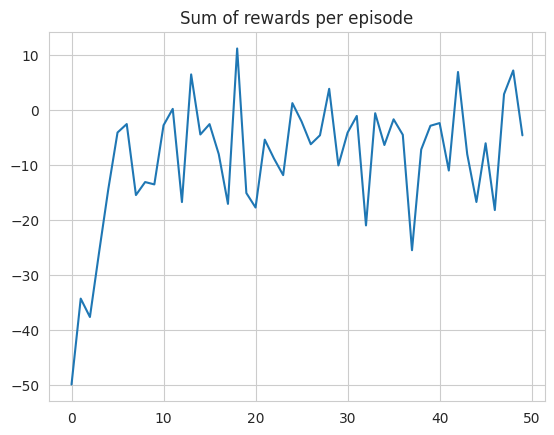

Sum of rewards per episode:  [-49.888775862208085, -34.28143552478871, -37.6248231812118, -25.826895682144137, -14.360767960214195, -4.092039414538279, -2.553396258166214, -15.46130165792492, -13.097860676208485, -13.525758768775153, -2.7784434375816884, 0.20319051874924626, -16.734227431272465, 6.467682034494911, -4.452983003182427, -2.5682221632295823, -8.023070703462121, -17.06504183671663, 11.179902640126464, -15.09896725520681, -17.729494682261496, -5.388521061995482, -8.819924920918707, -11.840872311785343, 1.2473521326881416, -2.0930062960756217, -6.223151709575542, -4.594875255843312, 3.848769865709473, -10.076693558508136, -4.119133234885143, -1.0819007157171674, -20.97913907652238, -0.5817561823556598, -6.363916676297632, -1.6915584216854849, -4.5076955447789695, -25.487428729532805, -7.189154004006564, -2.866503492280227, -2.3791691038673433, -10.999623297827338, 6.907535455398584, -8.02833786659362, -16.723723267387033, -6.053142317227653, -18.186849899349312, 2.87104714679

In [40]:
sum_reward(scalar_results_list)

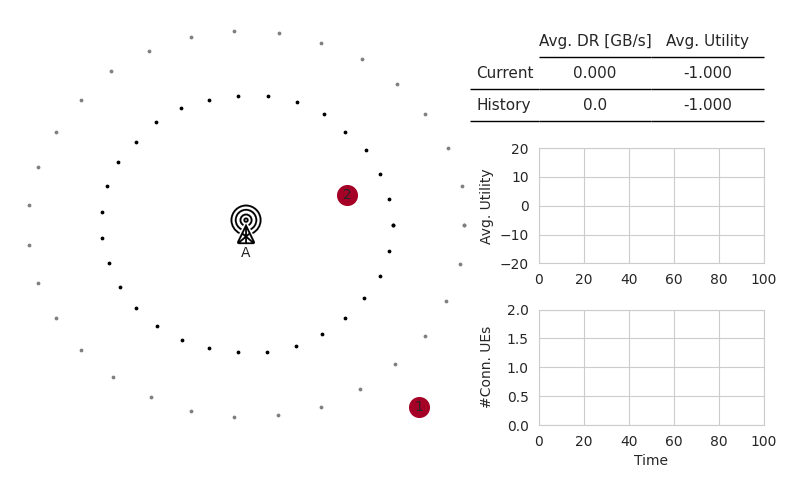

In [46]:
env = CustomEnv(render_mode="rgb_array")
obs, info = env.reset()
done = False
frames = []

# run one episode with the trained model
while not done:
  state = torch.FloatTensor(state).unsqueeze(0)
  probs = actor(state)
  dist = torch.distributions.Categorical(probs)
  action_idx = dist.sample().item()
  unraveled_action = np.unravel_index(action_idx, action_dim)
  action = tuple(map(int, unraveled_action))
  selected_actions.append(action)

  next_state, reward, terminated, truncated, info = env.step(action)
  state = next_state
  done = terminated or truncated
  frames.append(env.render())

write_apng("rendered.png", frames, delay=80)  # real-time rendering = 40 ms between frames
display(Image(filename="rendered.png"))